<a href="https://colab.research.google.com/github/harinikannan2811-pixel/Harini/blob/main/AI_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install keras-tuner shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt

import shap


In [3]:
"""
SIMULATION RATIONALE:
- trend: slowly increasing long-term behavior
- seasonal: periodic component with fixed period (50)
- feature_1..3: stochastic drivers (noise-like)
- target: depends on trend + seasonality + interaction feature_3*seasonal + noise
This creates a realistic multivariate time series with:
- non-stationarity (trend)
- seasonality
- feature interactions
- noisy observations
"""

np.random.seed(42)

n_obs = 1200
time = np.arange(n_obs)

data = pd.DataFrame({
    "trend": time * 0.01,
    "seasonal": np.sin(2 * np.pi * time / 50),
    "feature_1": np.random.normal(0, 1, n_obs),
    "feature_2": np.random.normal(0, 1, n_obs),
    "feature_3": np.random.normal(0, 1, n_obs)
})

data["target"] = (
    0.5 * data["trend"]
    + 2.0 * data["seasonal"]
    + 0.3 * data["feature_1"]
    - 0.2 * data["feature_2"]
    + 0.25 * (data["feature_3"] * data["seasonal"])  # interaction term
    + np.random.normal(0, 0.5, n_obs)
)

data.head()


,trend,seasonal,feature_1,feature_2,feature_3,target
0,0.00,0.000000,0.496714,0.125225,-0.721738,-0.287998
1,0.01,0.125333,-0.138264,-0.429406,0.176821,-0.053946
2,0.02,0.248690,0.647689,0.122298,-0.546680,1.668144
3,0.03,0.368125,1.523030,0.543298,-0.271655,1.074839
4,0.04,0.481754,-0.234153,0.048860,1.673452,1.496102


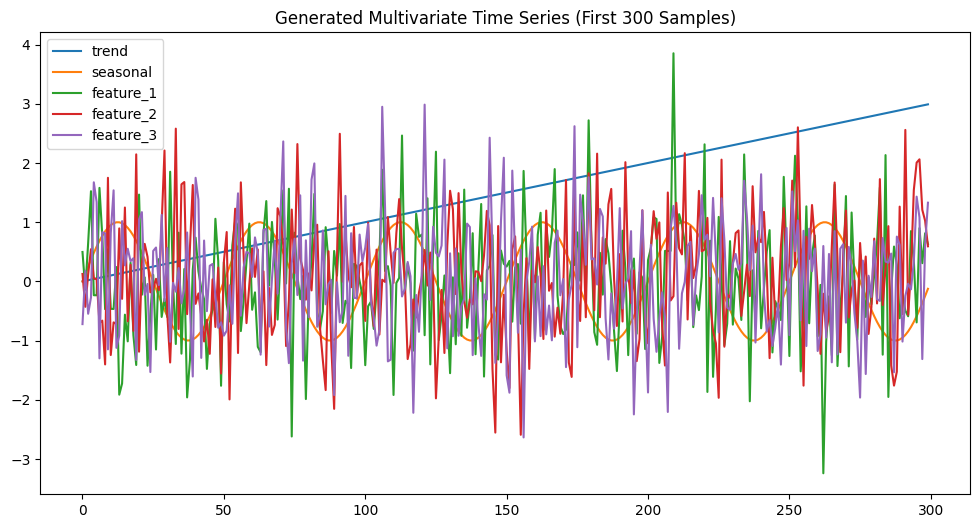

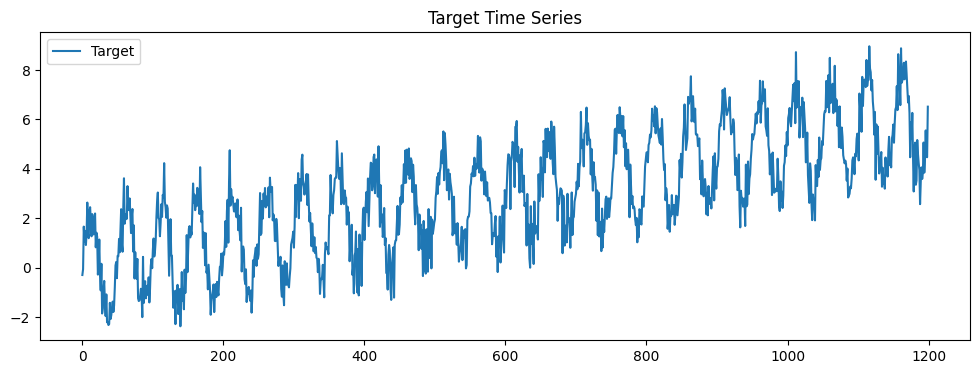

In [4]:
data[["trend", "seasonal", "feature_1", "feature_2", "feature_3"]].iloc[:300].plot(
    figsize=(12, 6),
    title="Generated Multivariate Time Series (First 300 Samples)"
)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(data["target"], label="Target")
plt.title("Target Time Series")
plt.legend()
plt.show()


In [5]:
features = data.drop(columns=["target"])
target = data["target"].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)


In [6]:
def create_sequences(X, y, window=30, horizon=3):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        Xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon].flatten())
    return np.array(Xs), np.array(ys)

WINDOW = 30
HORIZON = 3

X_seq, y_seq = create_sequences(X_scaled, y_scaled, WINDOW, HORIZON)

print("X_seq:", X_seq.shape)
print("y_seq:", y_seq.shape)


X_seq: (1168, 30, 5)
y_seq: (1168, 3)


In [7]:
def rolling_origin_splits(X, y, initial_train_size, val_size, step_size):
    """
    Generates rolling-origin splits.
    Train grows each fold, validation moves forward.
    """
    splits = []
    start = initial_train_size

    while start + val_size <= len(X):
        train_idx = np.arange(0, start)
        val_idx = np.arange(start, start + val_size)
        splits.append((train_idx, val_idx))
        start += step_size

    return splits


splits = rolling_origin_splits(
    X_seq, y_seq,
    initial_train_size=600,
    val_size=150,
    step_size=150
)

print("Number of folds:", len(splits))
for i, (tr, va) in enumerate(splits):
    print(f"Fold {i+1}: train={len(tr)} val={len(va)}")


Number of folds: 3
Fold 1: train=600 val=150
Fold 2: train=750 val=150
Fold 3: train=900 val=150


In [8]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(WINDOW, X_seq.shape[2])))

    model.add(layers.LSTM(
        units=hp.Int("units", 32, 128, step=32),
        return_sequences=False
    ))

    model.add(layers.Dropout(hp.Float("dropout", 0.0, 0.3, step=0.1)))

    model.add(layers.Dense(HORIZON))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse"
    )
    return model


In [9]:
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return rmse, mae, mape


fold_results = []
all_fold_predictions = []

for fold, (train_idx, val_idx) in enumerate(splits, start=1):
    print("\n============================")
    print("Fold", fold)
    print("============================")

    X_train, y_train = X_seq[train_idx], y_seq[train_idx]
    X_val, y_val = X_seq[val_idx], y_seq[val_idx]

    tuner = kt.RandomSearch(
        build_model,
        objective="val_loss",
        max_trials=3,  # keep small for Colab runtime
        directory="tuning_dir",
        project_name=f"fold_{fold}"
    )

    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        verbose=0
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]

    # Rebuild model fresh (safe)
    model = tf.keras.Sequential([
        layers.Input(shape=(WINDOW, X_seq.shape[2])),
        layers.LSTM(best_hp.get("units")),
        layers.Dropout(best_hp.get("dropout")),
        layers.Dense(HORIZON)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get("lr")),
        loss="mse"
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        verbose=0
    )

    preds_scaled = model.predict(X_val)

    # Inverse transform to ORIGINAL target scale
    y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1)).reshape(-1, HORIZON)
    preds_inv = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(-1, HORIZON)

    rmse, mae, mape = compute_metrics(y_val_inv, preds_inv)

    print(f"Fold {fold} RMSE: {rmse:.4f}")
    print(f"Fold {fold} MAE : {mae:.4f}")
    print(f"Fold {fold} MAPE: {mape:.2f}%")

    fold_results.append((rmse, mae, mape))
    all_fold_predictions.append((y_val_inv, preds_inv))

# Average CV results
fold_results = np.array(fold_results)
print("\n============================")
print("Rolling-Origin CV Average")
print("============================")
print("Avg RMSE:", fold_results[:, 0].mean())
print("Avg MAE :", fold_results[:, 1].mean())
print("Avg MAPE:", fold_results[:, 2].mean())



Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 1 RMSE: 0.7047
Fold 1 MAE : 0.5769
Fold 1 MAPE: 141.47%

Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fold 2 RMSE: 0.5847
Fold 2 MAE : 0.4693
Fold 2 MAPE: 12.70%

Fold 3


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Fold 3 RMSE: 0.6853
Fold 3 MAE : 0.5525
Fold 3 MAPE: 13.73%

Rolling-Origin CV Average
Avg RMSE: 0.6582355344720333
Avg MAE : 0.5328993159351849
Avg MAPE: 55.96814784926824


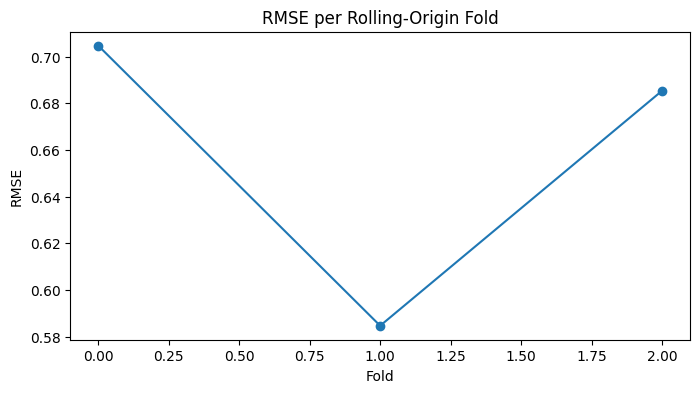

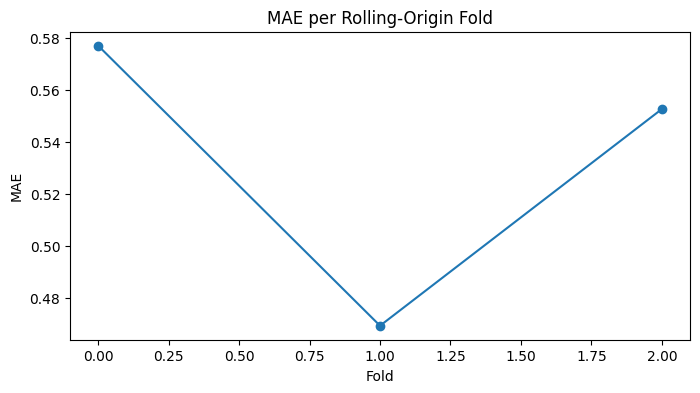

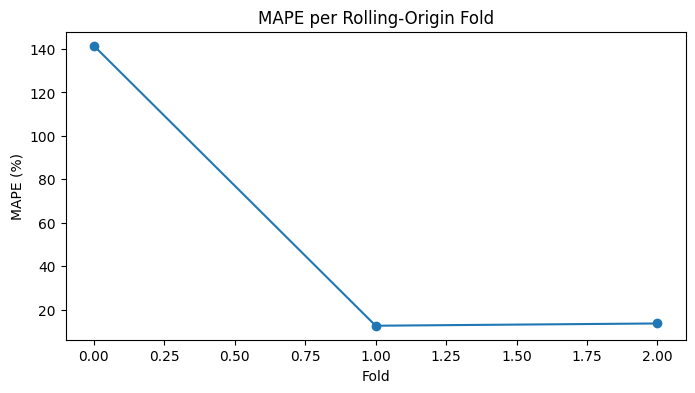

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(fold_results[:, 0], marker="o")
plt.title("RMSE per Rolling-Origin Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(fold_results[:, 1], marker="o")
plt.title("MAE per Rolling-Origin Fold")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(fold_results[:, 2], marker="o")
plt.title("MAPE per Rolling-Origin Fold")
plt.xlabel("Fold")
plt.ylabel("MAPE (%)")
plt.show()


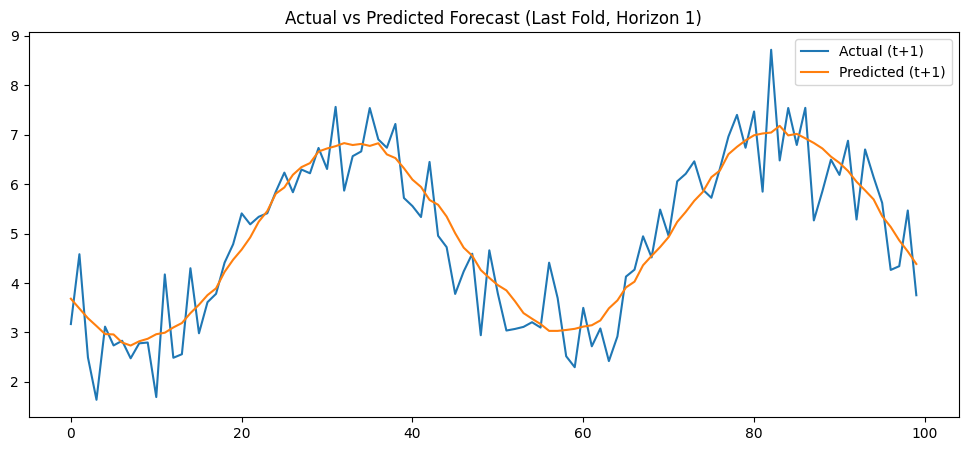

In [11]:
# Plot last fold predictions
y_true_plot, y_pred_plot = all_fold_predictions[-1]

plt.figure(figsize=(12, 5))
plt.plot(y_true_plot[:100, 0], label="Actual (t+1)")
plt.plot(y_pred_plot[:100, 0], label="Predicted (t+1)")
plt.title("Actual vs Predicted Forecast (Last Fold, Horizon 1)")
plt.legend()
plt.show()


In [12]:
# Train a final model on the last split for SHAP explanation
train_idx, val_idx = splits[-1]
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val, y_val = X_seq[val_idx], y_seq[val_idx]

# Build final model using best hyperparameters from last fold
final_model = model  # last trained model


In [13]:
def shap_model_wrapper(x_flat):
    x_3d = x_flat.reshape(-1, WINDOW, X_seq.shape[2])
    return final_model.predict(x_3d)

# background + samples
background = X_train[:40].reshape(40, -1)
samples = X_val[:10].reshape(10, -1)

explainer = shap.KernelExplainer(shap_model_wrapper, background)
shap_values = explainer.shap_values(samples)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2935/2935 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


/tmp/ipython-input-4160971061.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, samples, feature_names=feature_names)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/pl

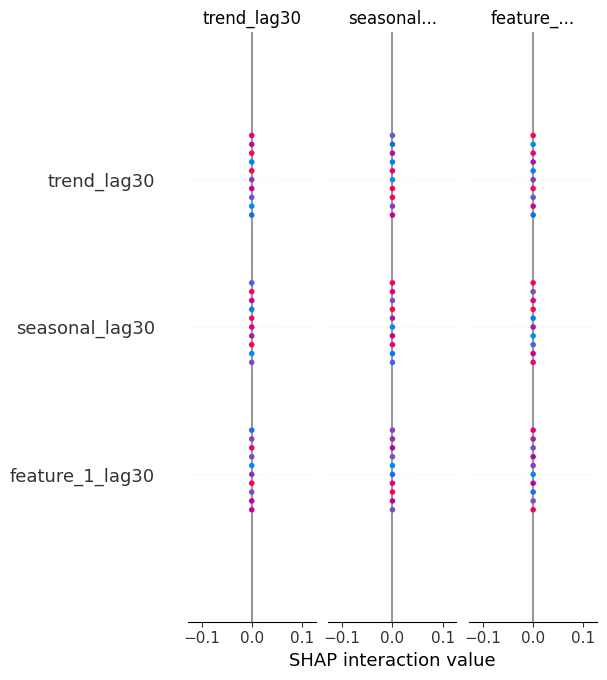

In [14]:
feature_names = []
for t in range(WINDOW):
    for f in features.columns:
        feature_names.append(f"{f}_lag{WINDOW-t}")

shap.summary_plot(shap_values, samples, feature_names=feature_names)
